# Training a classifier

We're going to train an image classifier on the CIFAR10 dataset. Pytorch has some modules that has data loaders for common datasets: `torchvision.datasets` and `torch.utils.data.DataLoader`

We will do the following steps:
1. Load and preprocess the training data
2. Define a CNN
3. Define a loss function
4. Train the network
5. Test the network on test data

## 1. Loading CIFAR10 data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Let's download the train/test set data from a remote repository

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
          'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Visually inspect some of the training images

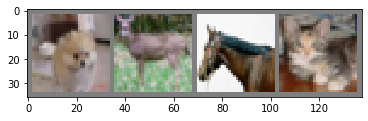

  dog  deer horse   cat


In [3]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define a CNN

In [4]:
# The dataloader makes minibatches with 4 samples, each with
# 3 channels, and (32, 32) size
images.shape

torch.Size([4, 3, 32, 32])

In [42]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # (6, 28, 28)
        self.pool = nn.MaxPool2d(2, 2) # (6, 14, 14)
        self.conv2 = nn.Conv2d(6, 16, 5) # (16, 10, 10)
        # Another pool operation here (16, 5, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

## Loss function and optimizer

In [43]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [33]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5s] loss: %.3f' %
                 (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

print('Finished training')

[1,  2000] loss: 2.223
[1,  4000] loss: 1.899
[1,  6000] loss: 1.693
[1,  8000] loss: 1.575
[1, 10000] loss: 1.514
[1, 12000] loss: 1.476
[2,  2000] loss: 1.408
[2,  4000] loss: 1.379
[2,  6000] loss: 1.351
[2,  8000] loss: 1.306
[2, 10000] loss: 1.322
[2, 12000] loss: 1.288
Finished training


In [34]:
# save our model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test the network on test data

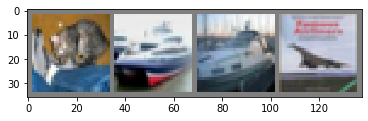

GroundTruth:    cat  ship  ship plane


In [35]:
# display some images from the test set
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [36]:
# reload the saved network state
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car  ship  ship


In [37]:
# See how the network performs on the whole dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on 10,000 test images: %d %%' % (
    100 * correct/ total))

Accuracy of the network on 10,000 test images: 53 %


In [38]:
# what are classes that performed well?
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (
        classes[i], 100 * class_correct[i]/class_total[i]))

Accuracy of plane: 59 %
Accuracy of   car: 75 %
Accuracy of  bird: 22 %
Accuracy of   cat: 20 %
Accuracy of  deer: 33 %
Accuracy of   dog: 79 %
Accuracy of  frog: 66 %
Accuracy of horse: 56 %
Accuracy of  ship: 66 %
Accuracy of truck: 53 %


## Train on GPU

In [44]:
device = torch.device("cuda:0")
print(device)

cuda:0


In [45]:
# It's really that simple??
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [47]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = (d.to(device) for d in data)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5s] loss: %.3f' %
                 (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

print('Finished training')

[1,  2000] loss: 2.219
[1,  4000] loss: 1.863
[1,  6000] loss: 1.650
[1,  8000] loss: 1.592
[1, 10000] loss: 1.522
[1, 12000] loss: 1.470
[2,  2000] loss: 1.420
[2,  4000] loss: 1.368
[2,  6000] loss: 1.359
[2,  8000] loss: 1.346
[2, 10000] loss: 1.302
[2, 12000] loss: 1.289
Finished training
